In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from skimage.feature import hog
from sklearn.utils import shuffle

import pandas as pd  
from keras.models import Sequential
from keras.models import Model
from keras.layers import ELU
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Lambda
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.models import model_from_json

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import simplejson as json
import random

Using TensorFlow backend.


In [2]:
def showGrayImage(img):
    imgShow = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    imgShow[:,:,2] = imgShow[:,:,0]*255
    imgShow[:,:,0:2] = 0    
    
    plt.imshow(imgShow)            
    plt.show()

In [3]:
rootDir = "object-detection-crowdai/"
csvFile = pd.read_csv(rootDir+'labels.csv', header=0)

dataFile = csvFile[(csvFile['Label']!='Pedestrian')].reset_index()
dataFile = dataFile.drop('index', 1)
dataFile = dataFile.drop('Preview URL', 1)
dataFile['Frame'] = './' + rootDir + dataFile['Frame']
dataFile.columns = ['xmin', 'ymin', 'xmax','ymax', 'Frame', 'Label']
dataFile.head(10)

,xmin,ymin,xmax,ymax,Frame,Label
0,785,533,905,644,./object-detection-crowdai/1479498371963069978...,Car
1,89,551,291,680,./object-detection-crowdai/1479498371963069978...,Car
2,268,546,383,650,./object-detection-crowdai/1479498371963069978...,Car
3,455,522,548,615,./object-detection-crowdai/1479498371963069978...,Truck
4,548,522,625,605,./object-detection-crowdai/1479498371963069978...,Truck
5,1726,484,1919,646,./object-detection-crowdai/1479498371963069978...,Car
6,758,557,807,617,./object-detection-crowdai/1479498371963069978...,Car
7,633,561,680,597,./object-detection-crowdai/1479498371963069978...,Car
8,682,557,718,593,./object-detection-crowdai/1479498371963069978...,Car
9,710,540,836,665,./object-detection-crowdai/1479498372942264998...,Car


In [4]:
names = ['Frame',  'xmin', 'ymin', 'xmax','ymax', 'occluded', 'Label']
rootDir = "object-dataset/"
csvFile1 = pd.read_csv(rootDir+'labels.csv', delim_whitespace=True, names=names)
dataFile1 = csvFile1[(csvFile1['Label']!=str.lower('Pedestrian'))].reset_index()
dataFile1 = dataFile1.drop('index',1)
dataFile1 = dataFile1.drop('occluded',1)
dataFile1['Frame'] = './' + rootDir + dataFile1['Frame']
dataFile1.tail(10)


,Frame,xmin,ymin,xmax,ymax,Label
83210,./object-dataset/1478901535817639152.jpg,162,598,404,754,car
83211,./object-dataset/1478901535817639152.jpg,400,592,506,714,car
83212,./object-dataset/1478901535817639152.jpg,1118,556,1346,740,car
83213,./object-dataset/1478901536388465963.jpg,234,594,388,728,car
83214,./object-dataset/1478901536388465963.jpg,364,604,430,678,car
83215,./object-dataset/1478901536388465963.jpg,1048,552,1348,748,car
83216,./object-dataset/1478901536960505700.jpg,0,606,142,780,car
83217,./object-dataset/1478901536960505700.jpg,146,604,246,692,car
83218,./object-dataset/1478901536960505700.jpg,710,582,800,618,car
83219,./object-dataset/1478901536960505700.jpg,896,546,1228,790,car


In [5]:
dataFile.tail()

,xmin,ymin,xmax,ymax,Frame,Label
66384,958,559,1045,621,./object-detection-crowdai/1479506176491553178...,Car
66385,1038,558,1122,630,./object-detection-crowdai/1479506176491553178...,Car
66386,667,558,747,626,./object-detection-crowdai/1479506176491553178...,Car
66387,730,568,818,613,./object-detection-crowdai/1479506176491553178...,Car
66388,435,551,532,589,./object-detection-crowdai/1479506176491553178...,Car


In [6]:
from keras.models import model_from_json

with open('model.json', 'r') as jfile:
    model = model_from_json(json.loads(jfile.read())) 
    print('model loaded')

model.compile(optimizer=Adam(lr=1e-4), loss="mse", metrics=['accuracy'])
weights_file = 'model.h5'
model.load_weights(weights_file)


#result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)

model loaded


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


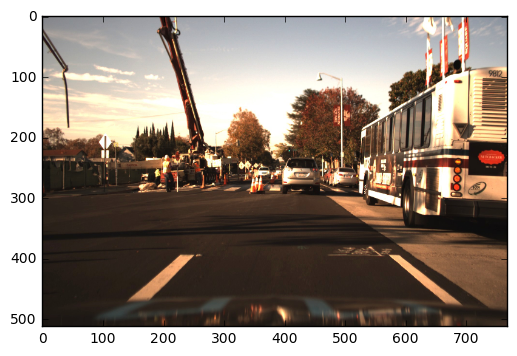

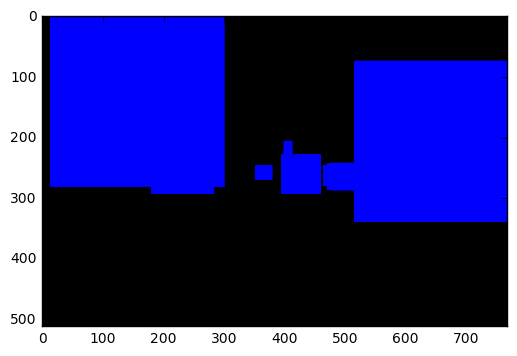

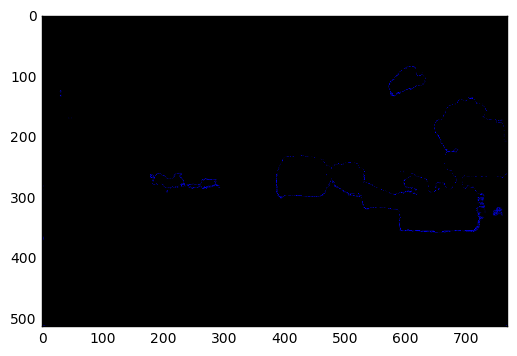

(512, 768, 1)
Original image


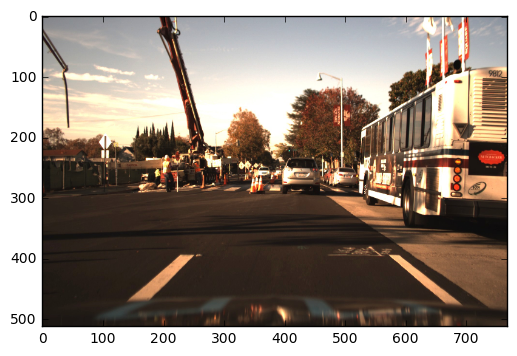

Predicted segmentation mask


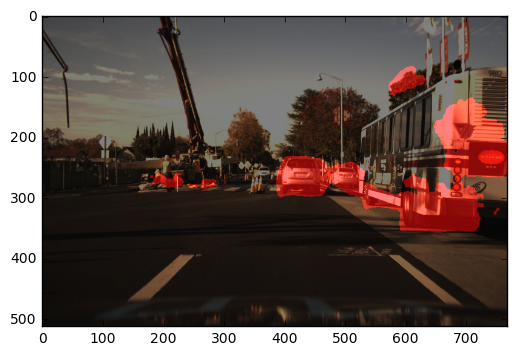

Ground truth BB


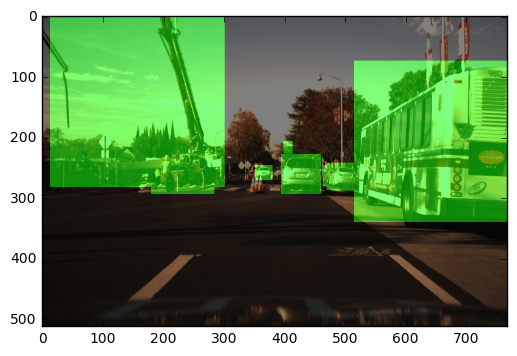

In [7]:
train_samples_per_epoch = 2560
valid_samples_per_epoch = 16384
trainBatchSize = 16
validationBatchSize = 64
imgRow = 512
imgCol = 768
def TrainDataGenerator(dataInfoList,batchSize,rootDir):
    batch_x, batch_y = [], []
    while True:
        dataInfo = dataInfoList[random.randint(0,1)]
        row = np.random.randint(len(dataInfo))
        fileName = dataInfo['Frame'][row]
        # print(fileName, row)
        img = cv2.imread(fileName)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        origShape = img.shape
        img = cv2.resize(img, (imgCol, imgRow))
        
        data = dataInfo[dataInfo['Frame'][row] == dataInfo['Frame']].reset_index()
        data['xmin'] = np.round(data['xmin'] / origShape[1] * imgCol)
        data['xmax'] = np.round(data['xmax'] / origShape[1] * imgCol)
        data['ymin'] = np.round(data['ymin'] / origShape[0] * imgRow)
        data['ymax'] = np.round(data['ymax'] / origShape[0] * imgRow)
        img1 = img.copy()
        '''targetImg = np.reshape(np.zeros_like(img[:, :, 2]), (imgRow, imgCol, 1))
        for i in range(len(data)):
            targetImg[data.iloc[i]['ymin']:data.iloc[i]['ymax'], data.iloc[i]['xmin']:data.iloc[i]['xmax']] = 1
            cv2.rectangle(img1, (int(data.iloc[i]['xmin']),int(data.iloc[i]['ymin'])), (int(data.iloc[i]['xmax']),int(data.iloc[i]['ymax'])), (0,0,255),6)'''
        
        targetImg = np.zeros_like(img[:, :, 2])
        for i in range(len(data)):
            targetImg[data.iloc[i]['ymin']:data.iloc[i]['ymax'], data.iloc[i]['xmin']:data.iloc[i]['xmax']] = 1

        targetImg = np.reshape(targetImg, (imgRow, imgCol, 1))
        plt.imshow(img1)
        plt.show()
        showGrayImage(targetImg)        
        batch_x.append(img)
        batch_y.append(targetImg)
        
        xy_array = np.asarray(img)
        xy_array = np.reshape(xy_array,(1,imgRow,imgCol,3))
        
        img = model.predict(xy_array)
        showGrayImage(img[0])  
        print(targetImg.shape)
        batch_mask  = np.reshape(targetImg,(1,imgRow,imgCol,1))
        pred_all = img
        batch_img = xy_array
        i=0    
        im = np.array(batch_img[i],dtype=np.uint8)
        im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
        im_pred = np.array(255*pred_all[i],dtype=np.uint8)

        rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
        rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
        rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
        rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
        rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

        img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
        img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

        #plt.figure(figsize=(8,3))
        #plt.subplot(1,3,1)
        print('Original image')
        plt.imshow(im)
        plt.show()
        #plt.title('Original image')
        #plt.axis('off')
        #plt.subplot(1,3,2)
        print('Predicted segmentation mask')
        plt.imshow(img_pred)
        plt.show()
        #plt.title('Predicted segmentation mask')
        #plt.axis('off')
        #plt.subplot(1,3,3)
        print('Ground truth BB')
        plt.imshow(img_true)
        plt.show()
        
        #plt.title('Ground truth BB')
        #plt.axis('off')
        plt.show()
        
        
        break
    
trainGenerator = TrainDataGenerator((dataFile,dataFile1),trainBatchSize,rootDir)    

In [6]:
print(targetImg)

NameError: name 'targetImg' is not defined

In [9]:

def process_frame(img):
    #plt.imshow(img)
    #plt.show()
    img = cv2.resize(img,(imgCol,imgRow))    
    
    x_array = np.asarray(img)
    x_array = np.reshape(x_array,(1,imgRow,imgCol,3))
    
    img = model.predict(x_array,verbose=1)    
    
    imgShow = cv2.cvtColor(img[0],cv2.COLOR_GRAY2RGB)
    
    imgShow[:,:,2] = imgShow[:,:,0]*255
    imgShow[:,:,0:2] = 0    
    
    plt.subplot(2,2,2)
    
    
    
    
    #batch_mask  = np.reshape(targetImg,(1,imgRow,imgCol,1))
    pred_all = img
    batch_img = x_array
    i=0    
    im = np.array(batch_img[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)

    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    
    #print('Original image')
    #plt.imshow(im)
    #plt.show()
    #print('Predicted segmentation mask')
    #plt.imshow(img_pred)
    #plt.show()
    #print('Ground truth BB')
    #plt.imshow(img_true)
    #plt.show()

    #plt.title('Ground truth BB')
    #plt.axis('off')
    
        
    
    
    return img_pred

In [10]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('./project_video.mp4')
outClip = clip.fl_image(process_frame)
outClip.write_videofile('./output_video.mp4', audio=False)

1/1 [==============================] - 0s
[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

1/1 [==============================] - 0s


  0%|▏                                                                                | 2/1261 [00:00<01:06, 18.99it/s]

1/1 [==============================] - 0s


  0%|▎                                                                                | 4/1261 [00:00<01:06, 18.83it/s]

1/1 [==============================] - 0s


  0%|▍                                                                                | 6/1261 [00:00<01:07, 18.62it/s]

1/1 [==============================] - 0s


  1%|▌                                                                                | 8/1261 [00:00<01:07, 18.49it/s]

1/1 [==============================] - 0s


  1%|▋                                                                               | 10/1261 [00:00<01:07, 18.41it/s]

1/1 [==============================] - 0s


  1%|▊                                                                               | 12/1261 [00:00<01:07, 18.38it/s]

1/1 [==============================] - 0s


  1%|▉                                                                               | 14/1261 [00:00<01:08, 18.25it/s]

1/1 [==============================] - 0s


  1%|█                                                                               | 16/1261 [00:00<01:09, 17.97it/s]

1/1 [==============================] - 0s


  1%|█▏                                                                              | 18/1261 [00:00<01:09, 17.92it/s]

1/1 [==============================] - 0s


  2%|█▎                                                                              | 20/1261 [00:01<01:09, 17.86it/s]

1/1 [==============================] - 0s


  2%|█▍                                                                              | 22/1261 [00:01<01:09, 17.87it/s]

1/1 [==============================] - 0s


  2%|█▌                                                                              | 24/1261 [00:01<01:08, 18.00it/s]

1/1 [==============================] - 0s


  2%|█▋                                                                              | 26/1261 [00:01<01:08, 18.11it/s]

1/1 [==============================] - 0s


  2%|█▊                                                                              | 28/1261 [00:01<01:07, 18.21it/s]

1/1 [==============================] - 0s


  2%|█▉                                                                              | 30/1261 [00:01<01:07, 18.16it/s]

1/1 [==============================] - 0s


  3%|██                                                                              | 32/1261 [00:01<01:07, 18.20it/s]

1/1 [==============================] - 0s


  3%|██▏                                                                             | 34/1261 [00:01<01:06, 18.38it/s]

1/1 [==============================] - 0s


  3%|██▎                                                                             | 36/1261 [00:01<01:06, 18.51it/s]

1/1 [==============================] - 0s


  3%|██▍                                                                             | 38/1261 [00:02<01:06, 18.45it/s]

1/1 [==============================] - 0s


  3%|██▌                                                                             | 40/1261 [00:02<01:05, 18.56it/s]

1/1 [==============================] - 0s


  3%|██▋                                                                             | 42/1261 [00:02<01:05, 18.63it/s]

1/1 [==============================] - 0s


  3%|██▊                                                                             | 44/1261 [00:02<01:05, 18.51it/s]

1/1 [==============================] - 0s


  4%|██▉                                                                             | 46/1261 [00:02<01:05, 18.48it/s]

1/1 [==============================] - 0s


  4%|███                                                                             | 48/1261 [00:02<01:05, 18.43it/s]

1/1 [==============================] - 0s


  4%|███▏                                                                            | 50/1261 [00:02<01:05, 18.44it/s]

1/1 [==============================] - 0s


  4%|███▎                                                                            | 52/1261 [00:02<01:05, 18.58it/s]

1/1 [==============================] - 0s


  4%|███▍                                                                            | 54/1261 [00:02<01:05, 18.52it/s]

1/1 [==============================] - 0s


  4%|███▌                                                                            | 56/1261 [00:03<01:05, 18.48it/s]

1/1 [==============================] - 0s


  5%|███▋                                                                            | 58/1261 [00:04<06:15,  3.21it/s]

1/1 [==============================] - 0s


  5%|███▊                                                                            | 60/1261 [00:04<04:42,  4.26it/s]

1/1 [==============================] - 0s


  5%|███▉                                                                            | 62/1261 [00:05<03:38,  5.50it/s]

1/1 [==============================] - 0s


  5%|████                                                                            | 64/1261 [00:05<02:54,  6.84it/s]

1/1 [==============================] - 0s


  5%|████▏                                                                           | 66/1261 [00:05<02:23,  8.35it/s]

1/1 [==============================] - 0s


  5%|████▎                                                                           | 68/1261 [00:05<02:00,  9.90it/s]

1/1 [==============================] - 0s


  6%|████▍                                                                           | 70/1261 [00:05<01:43, 11.49it/s]

1/1 [==============================] - 0s


  6%|████▌                                                                           | 72/1261 [00:05<01:32, 12.84it/s]

1/1 [==============================] - 0s


  6%|████▋                                                                           | 74/1261 [00:05<01:23, 14.13it/s]

1/1 [==============================] - 0s


  6%|████▊                                                                           | 76/1261 [00:05<01:18, 15.10it/s]

1/1 [==============================] - 0s


  6%|████▉                                                                           | 78/1261 [00:06<01:15, 15.69it/s]

1/1 [==============================] - 0s


  6%|█████                                                                           | 80/1261 [00:06<01:13, 16.15it/s]

1/1 [==============================] - 0s


  7%|█████▏                                                                          | 82/1261 [00:06<01:10, 16.74it/s]

1/1 [==============================] - 0s


  7%|█████▎                                                                          | 84/1261 [00:06<01:07, 17.31it/s]

1/1 [==============================] - 0s


  7%|█████▍                                                                          | 86/1261 [00:06<01:07, 17.47it/s]

1/1 [==============================] - 0s


  7%|█████▌                                                                          | 88/1261 [00:06<01:06, 17.61it/s]

1/1 [==============================] - 0s


  7%|█████▋                                                                          | 90/1261 [00:06<01:05, 17.77it/s]

1/1 [==============================] - 0s


  7%|█████▊                                                                          | 92/1261 [00:06<01:05, 17.94it/s]

1/1 [==============================] - 0s


  7%|█████▉                                                                          | 94/1261 [00:06<01:05, 17.88it/s]

1/1 [==============================] - 0s


  8%|██████                                                                          | 96/1261 [00:07<01:05, 17.76it/s]

1/1 [==============================] - 0s


  8%|██████▏                                                                         | 98/1261 [00:07<01:04, 17.99it/s]

1/1 [==============================] - 0s


  8%|██████▎                                                                        | 100/1261 [00:07<01:04, 18.03it/s]

1/1 [==============================] - 0s


  8%|██████▍                                                                        | 102/1261 [00:07<01:04, 17.96it/s]

1/1 [==============================] - 0s


  8%|██████▌                                                                        | 104/1261 [00:07<01:04, 18.06it/s]

1/1 [==============================] - 0s


  8%|██████▋                                                                        | 106/1261 [00:07<01:04, 17.94it/s]

1/1 [==============================] - 0s


  9%|██████▊                                                                        | 108/1261 [00:07<01:04, 17.95it/s]

1/1 [==============================] - 0s


  9%|██████▉                                                                        | 110/1261 [00:07<01:04, 17.90it/s]

1/1 [==============================] - 0s


  9%|███████                                                                        | 112/1261 [00:07<01:04, 17.85it/s]

1/1 [==============================] - 0s


  9%|███████▏                                                                       | 114/1261 [00:08<01:03, 17.93it/s]

1/1 [==============================] - 0s


  9%|███████▎                                                                       | 116/1261 [00:08<01:03, 18.09it/s]

1/1 [==============================] - 0s


  9%|███████▍                                                                       | 118/1261 [00:08<01:02, 18.20it/s]

1/1 [==============================] - 0s


 10%|███████▌                                                                       | 120/1261 [00:08<01:03, 17.98it/s]

1/1 [==============================] - 0s


 10%|███████▋                                                                       | 122/1261 [00:08<01:03, 17.98it/s]

1/1 [==============================] - 0s


 10%|███████▊                                                                       | 124/1261 [00:08<01:03, 17.94it/s]

1/1 [==============================] - 0s


 10%|███████▉                                                                       | 126/1261 [00:08<01:03, 17.95it/s]

1/1 [==============================] - 0s


 10%|████████                                                                       | 128/1261 [00:08<01:02, 18.05it/s]

1/1 [==============================] - 0s


 10%|████████▏                                                                      | 130/1261 [00:08<01:03, 17.93it/s]

1/1 [==============================] - 0s


 10%|████████▎                                                                      | 132/1261 [00:09<01:02, 17.95it/s]

1/1 [==============================] - 0s


 11%|████████▍                                                                      | 134/1261 [00:09<01:02, 18.05it/s]

1/1 [==============================] - 0s


 11%|████████▌                                                                      | 136/1261 [00:09<01:03, 17.86it/s]

1/1 [==============================] - 0s


 11%|████████▋                                                                      | 138/1261 [00:09<01:03, 17.72it/s]

1/1 [==============================] - 0s


 11%|████████▊                                                                      | 140/1261 [00:09<01:02, 17.92it/s]

1/1 [==============================] - 0s


 11%|████████▉                                                                      | 142/1261 [00:09<01:02, 17.93it/s]

1/1 [==============================] - 0s


 11%|█████████                                                                      | 144/1261 [00:09<01:01, 18.19it/s]

1/1 [==============================] - 0s


 12%|█████████▏                                                                     | 146/1261 [00:09<01:01, 18.22it/s]

1/1 [==============================] - 0s


 12%|█████████▎                                                                     | 148/1261 [00:09<01:02, 17.85it/s]

1/1 [==============================] - 0s


 12%|█████████▍                                                                     | 150/1261 [00:10<01:03, 17.46it/s]

1/1 [==============================] - 0s


 12%|█████████▌                                                                     | 152/1261 [00:10<01:02, 17.71it/s]

1/1 [==============================] - 0s


 12%|█████████▋                                                                     | 154/1261 [00:10<01:02, 17.74it/s]

1/1 [==============================] - 0s


 12%|█████████▊                                                                     | 156/1261 [00:10<01:02, 17.76it/s]

1/1 [==============================] - 0s


 13%|█████████▉                                                                     | 158/1261 [00:10<01:01, 17.97it/s]

1/1 [==============================] - 0s


 13%|██████████                                                                     | 160/1261 [00:10<01:01, 17.78it/s]

1/1 [==============================] - 0s


 13%|██████████▏                                                                    | 162/1261 [00:10<01:02, 17.64it/s]

1/1 [==============================] - 0s


 13%|██████████▎                                                                    | 164/1261 [00:10<01:01, 17.98it/s]

1/1 [==============================] - 0s


 13%|██████████▍                                                                    | 166/1261 [00:10<01:00, 18.18it/s]

1/1 [==============================] - 0s


 13%|██████████▌                                                                    | 168/1261 [00:11<01:00, 17.92it/s]

1/1 [==============================] - 0s


 13%|██████████▋                                                                    | 170/1261 [00:11<01:00, 17.99it/s]

1/1 [==============================] - 0s


 14%|██████████▊                                                                    | 172/1261 [00:11<01:00, 17.98it/s]

1/1 [==============================] - 0s


 14%|██████████▉                                                                    | 174/1261 [00:11<01:00, 18.03it/s]

1/1 [==============================] - 0s


 14%|███████████                                                                    | 176/1261 [00:11<01:00, 18.01it/s]

1/1 [==============================] - 0s


 14%|███████████▏                                                                   | 178/1261 [00:11<01:00, 18.00it/s]

1/1 [==============================] - 0s


 14%|███████████▎                                                                   | 180/1261 [00:11<00:59, 18.14it/s]

1/1 [==============================] - 0s


 14%|███████████▍                                                                   | 182/1261 [00:11<00:59, 18.18it/s]

1/1 [==============================] - 0s


 15%|███████████▌                                                                   | 184/1261 [00:11<00:58, 18.32it/s]

1/1 [==============================] - 0s


 15%|███████████▋                                                                   | 186/1261 [00:12<00:58, 18.31it/s]

1/1 [==============================] - 0s


 15%|███████████▊                                                                   | 188/1261 [00:12<00:59, 18.03it/s]

1/1 [==============================] - 0s


 15%|███████████▉                                                                   | 190/1261 [00:12<00:59, 17.99it/s]

1/1 [==============================] - 0s


 15%|████████████                                                                   | 192/1261 [00:12<00:59, 18.03it/s]

1/1 [==============================] - 0s


 15%|████████████▏                                                                  | 194/1261 [00:12<00:58, 18.11it/s]

1/1 [==============================] - 0s


 16%|████████████▎                                                                  | 196/1261 [00:12<00:58, 18.17it/s]

1/1 [==============================] - 0s


 16%|████████████▍                                                                  | 198/1261 [00:12<00:58, 18.26it/s]

1/1 [==============================] - 0s


 16%|████████████▌                                                                  | 200/1261 [00:12<00:59, 17.97it/s]

1/1 [==============================] - 0s


 16%|████████████▋                                                                  | 202/1261 [00:12<00:58, 18.07it/s]

1/1 [==============================] - 0s


 16%|████████████▊                                                                  | 204/1261 [00:13<00:58, 18.04it/s]

1/1 [==============================] - 0s


 16%|████████████▉                                                                  | 206/1261 [00:13<00:58, 18.06it/s]

1/1 [==============================] - 0s


 16%|█████████████                                                                  | 208/1261 [00:13<00:58, 17.99it/s]

1/1 [==============================] - 0s


 17%|█████████████▏                                                                 | 210/1261 [00:13<00:58, 17.88it/s]

1/1 [==============================] - 0s


 17%|█████████████▎                                                                 | 212/1261 [00:13<00:58, 17.96it/s]

1/1 [==============================] - 0s


 17%|█████████████▍                                                                 | 214/1261 [00:13<00:58, 17.85it/s]

1/1 [==============================] - 0s


 17%|█████████████▌                                                                 | 216/1261 [00:13<00:58, 17.74it/s]

1/1 [==============================] - 0s


 17%|█████████████▋                                                                 | 218/1261 [00:13<00:58, 17.93it/s]

1/1 [==============================] - 0s


 17%|█████████████▊                                                                 | 220/1261 [00:13<00:58, 17.94it/s]

1/1 [==============================] - 0s


 18%|█████████████▉                                                                 | 222/1261 [00:14<00:57, 18.09it/s]

1/1 [==============================] - 0s


 18%|██████████████                                                                 | 224/1261 [00:14<00:57, 18.15it/s]

1/1 [==============================] - 0s


 18%|██████████████▏                                                                | 226/1261 [00:14<00:56, 18.25it/s]

1/1 [==============================] - 0s


 18%|██████████████▎                                                                | 228/1261 [00:14<00:56, 18.36it/s]

1/1 [==============================] - 0s


 18%|██████████████▍                                                                | 230/1261 [00:14<00:56, 18.24it/s]

1/1 [==============================] - 0s


 18%|██████████████▌                                                                | 232/1261 [00:14<00:56, 18.31it/s]

1/1 [==============================] - 0s


 19%|██████████████▋                                                                | 234/1261 [00:14<00:55, 18.38it/s]

1/1 [==============================] - 0s


 19%|██████████████▊                                                                | 236/1261 [00:14<00:55, 18.32it/s]

1/1 [==============================] - 0s


 19%|██████████████▉                                                                | 238/1261 [00:14<00:55, 18.31it/s]

1/1 [==============================] - 0s


 19%|███████████████                                                                | 240/1261 [00:15<00:55, 18.27it/s]

1/1 [==============================] - 0s


 19%|███████████████▏                                                               | 242/1261 [00:15<00:55, 18.28it/s]

1/1 [==============================] - 0s


 19%|███████████████▎                                                               | 244/1261 [00:15<00:55, 18.28it/s]

1/1 [==============================] - 0s


 20%|███████████████▍                                                               | 246/1261 [00:15<00:55, 18.24it/s]

1/1 [==============================] - 0s


 20%|███████████████▌                                                               | 248/1261 [00:15<00:55, 18.21it/s]

1/1 [==============================] - 0s


 20%|███████████████▋                                                               | 250/1261 [00:15<00:55, 18.09it/s]

1/1 [==============================] - 0s


 20%|███████████████▊                                                               | 252/1261 [00:15<00:55, 18.03it/s]

1/1 [==============================] - 0s


 20%|███████████████▉                                                               | 254/1261 [00:15<00:55, 18.12it/s]

1/1 [==============================] - 0s


 20%|████████████████                                                               | 256/1261 [00:15<00:55, 18.05it/s]

1/1 [==============================] - 0s


 20%|████████████████▏                                                              | 258/1261 [00:16<00:55, 18.14it/s]

1/1 [==============================] - 0s


 21%|████████████████▎                                                              | 260/1261 [00:16<00:54, 18.24it/s]

1/1 [==============================] - 0s


 21%|████████████████▍                                                              | 262/1261 [00:16<00:55, 18.16it/s]

1/1 [==============================] - 0s


 21%|████████████████▌                                                              | 264/1261 [00:16<00:55, 18.02it/s]

1/1 [==============================] - 0s


 21%|████████████████▋                                                              | 266/1261 [00:16<00:55, 17.96it/s]

1/1 [==============================] - 0s


 21%|████████████████▊                                                              | 268/1261 [00:16<00:54, 18.13it/s]

1/1 [==============================] - 0s


 21%|████████████████▉                                                              | 270/1261 [00:16<00:54, 18.21it/s]

1/1 [==============================] - 0s


 22%|█████████████████                                                              | 272/1261 [00:16<00:54, 18.29it/s]

1/1 [==============================] - 0s


 22%|█████████████████▏                                                             | 274/1261 [00:16<00:53, 18.32it/s]

1/1 [==============================] - 0s


 22%|█████████████████▎                                                             | 276/1261 [00:16<00:53, 18.41it/s]

1/1 [==============================] - 0s


 22%|█████████████████▍                                                             | 278/1261 [00:17<00:53, 18.55it/s]

1/1 [==============================] - 0s


 22%|█████████████████▌                                                             | 280/1261 [00:17<00:52, 18.52it/s]

1/1 [==============================] - 0s


 22%|█████████████████▋                                                             | 282/1261 [00:17<00:53, 18.45it/s]

1/1 [==============================] - 0s


 23%|█████████████████▊                                                             | 284/1261 [00:17<00:53, 18.43it/s]

1/1 [==============================] - 0s


 23%|█████████████████▉                                                             | 286/1261 [00:17<00:53, 18.37it/s]

1/1 [==============================] - 0s


 23%|██████████████████                                                             | 288/1261 [00:17<00:52, 18.45it/s]

1/1 [==============================] - 0s


 23%|██████████████████▏                                                            | 290/1261 [00:17<00:53, 18.30it/s]

1/1 [==============================] - 0s


 23%|██████████████████▎                                                            | 292/1261 [00:17<00:52, 18.38it/s]

1/1 [==============================] - 0s


 23%|██████████████████▍                                                            | 294/1261 [00:17<00:52, 18.33it/s]

1/1 [==============================] - 0s


 23%|██████████████████▌                                                            | 296/1261 [00:18<00:52, 18.34it/s]

1/1 [==============================] - 0s


 24%|██████████████████▋                                                            | 298/1261 [00:18<00:52, 18.43it/s]

1/1 [==============================] - 0s


 24%|██████████████████▊                                                            | 300/1261 [00:18<00:51, 18.54it/s]

1/1 [==============================] - 0s


 24%|██████████████████▉                                                            | 302/1261 [00:18<00:51, 18.52it/s]

1/1 [==============================] - 0s


 24%|███████████████████                                                            | 304/1261 [00:18<00:51, 18.58it/s]

1/1 [==============================] - 0s


 24%|███████████████████▏                                                           | 306/1261 [00:18<00:51, 18.55it/s]

1/1 [==============================] - 0s


 24%|███████████████████▎                                                           | 308/1261 [00:18<00:51, 18.57it/s]

1/1 [==============================] - 0s


 25%|███████████████████▍                                                           | 310/1261 [00:18<00:51, 18.44it/s]

1/1 [==============================] - 0s


 25%|███████████████████▌                                                           | 312/1261 [00:18<00:51, 18.52it/s]

1/1 [==============================] - 0s


 25%|███████████████████▋                                                           | 314/1261 [00:19<00:50, 18.60it/s]

1/1 [==============================] - 0s


 25%|███████████████████▊                                                           | 316/1261 [00:19<00:51, 18.52it/s]

1/1 [==============================] - 0s


 25%|███████████████████▉                                                           | 318/1261 [00:19<00:51, 18.45it/s]

1/1 [==============================] - 0s


 25%|████████████████████                                                           | 320/1261 [00:19<00:50, 18.50it/s]

1/1 [==============================] - 0s


 26%|████████████████████▏                                                          | 322/1261 [00:19<00:50, 18.52it/s]

1/1 [==============================] - 0s


 26%|████████████████████▎                                                          | 324/1261 [00:19<00:50, 18.53it/s]

1/1 [==============================] - 0s


 26%|████████████████████▍                                                          | 326/1261 [00:19<00:50, 18.56it/s]

1/1 [==============================] - 0s


 26%|████████████████████▌                                                          | 328/1261 [00:19<00:50, 18.55it/s]

1/1 [==============================] - 0s


 26%|████████████████████▋                                                          | 330/1261 [00:19<00:50, 18.47it/s]

1/1 [==============================] - 0s


 26%|████████████████████▊                                                          | 332/1261 [00:20<00:50, 18.32it/s]

1/1 [==============================] - 0s


 26%|████████████████████▉                                                          | 334/1261 [00:20<00:50, 18.31it/s]

1/1 [==============================] - 0s


 27%|█████████████████████                                                          | 336/1261 [00:20<00:50, 18.25it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▏                                                         | 338/1261 [00:20<00:51, 18.07it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▎                                                         | 340/1261 [00:20<00:51, 17.99it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▍                                                         | 342/1261 [00:20<00:50, 18.15it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▌                                                         | 344/1261 [00:20<00:50, 18.33it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▋                                                         | 346/1261 [00:20<00:49, 18.39it/s]

1/1 [==============================] - 0s


 28%|█████████████████████▊                                                         | 348/1261 [00:20<00:49, 18.54it/s]

1/1 [==============================] - 0s


 28%|█████████████████████▉                                                         | 350/1261 [00:21<00:49, 18.47it/s]

1/1 [==============================] - 0s


 28%|██████████████████████                                                         | 352/1261 [00:21<00:48, 18.62it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▏                                                        | 354/1261 [00:21<00:49, 18.37it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▎                                                        | 356/1261 [00:21<00:48, 18.57it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▍                                                        | 358/1261 [00:21<00:48, 18.46it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▌                                                        | 360/1261 [00:21<00:48, 18.41it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▋                                                        | 362/1261 [00:21<00:49, 18.23it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▊                                                        | 364/1261 [00:21<00:48, 18.40it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▉                                                        | 366/1261 [00:21<00:48, 18.47it/s]

1/1 [==============================] - 0s


 29%|███████████████████████                                                        | 368/1261 [00:21<00:48, 18.47it/s]

1/1 [==============================] - 0s


 29%|███████████████████████▏                                                       | 370/1261 [00:22<00:47, 18.57it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▎                                                       | 372/1261 [00:22<00:47, 18.63it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▍                                                       | 374/1261 [00:22<00:47, 18.58it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▌                                                       | 376/1261 [00:22<00:47, 18.65it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▋                                                       | 378/1261 [00:22<00:47, 18.73it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▊                                                       | 380/1261 [00:22<00:47, 18.70it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▉                                                       | 382/1261 [00:22<00:47, 18.59it/s]

1/1 [==============================] - 0s


 30%|████████████████████████                                                       | 384/1261 [00:22<00:47, 18.66it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▏                                                      | 386/1261 [00:22<00:46, 18.71it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▎                                                      | 388/1261 [00:23<00:46, 18.74it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▍                                                      | 390/1261 [00:23<00:46, 18.71it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▌                                                      | 392/1261 [00:23<00:46, 18.64it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▋                                                      | 394/1261 [00:23<00:46, 18.53it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▊                                                      | 396/1261 [00:23<00:46, 18.43it/s]

1/1 [==============================] - 0s


 32%|████████████████████████▉                                                      | 398/1261 [00:23<00:46, 18.47it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████                                                      | 400/1261 [00:23<00:46, 18.49it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▏                                                     | 402/1261 [00:23<00:46, 18.55it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▎                                                     | 404/1261 [00:23<00:45, 18.63it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▍                                                     | 406/1261 [00:24<00:46, 18.58it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▌                                                     | 408/1261 [00:24<00:45, 18.60it/s]

1/1 [==============================] - 0s


 33%|█████████████████████████▋                                                     | 410/1261 [00:24<00:45, 18.51it/s]

1/1 [==============================] - 0s


 33%|█████████████████████████▊                                                     | 412/1261 [00:24<00:45, 18.52it/s]

1/1 [==============================] - 0s


 33%|█████████████████████████▉                                                     | 414/1261 [00:24<00:45, 18.50it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████                                                     | 416/1261 [00:24<00:46, 18.35it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▏                                                    | 418/1261 [00:24<00:45, 18.39it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▎                                                    | 420/1261 [00:24<00:46, 18.26it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▍                                                    | 422/1261 [00:24<00:45, 18.25it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▌                                                    | 424/1261 [00:25<00:45, 18.30it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▋                                                    | 426/1261 [00:25<00:45, 18.36it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▊                                                    | 428/1261 [00:25<00:45, 18.34it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▉                                                    | 430/1261 [00:25<00:45, 18.44it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████                                                    | 432/1261 [00:25<00:44, 18.47it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████▏                                                   | 434/1261 [00:25<00:44, 18.67it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▎                                                   | 436/1261 [00:25<00:44, 18.51it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▍                                                   | 438/1261 [00:25<00:44, 18.52it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▌                                                   | 440/1261 [00:25<00:43, 18.67it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▋                                                   | 442/1261 [00:25<00:43, 18.66it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▊                                                   | 444/1261 [00:26<00:43, 18.71it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▉                                                   | 446/1261 [00:26<00:43, 18.69it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████                                                   | 448/1261 [00:26<00:43, 18.62it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▏                                                  | 450/1261 [00:26<00:43, 18.58it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▎                                                  | 452/1261 [00:26<00:43, 18.54it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▍                                                  | 454/1261 [00:26<00:43, 18.44it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▌                                                  | 456/1261 [00:26<00:43, 18.45it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▋                                                  | 458/1261 [00:26<00:43, 18.61it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▊                                                  | 460/1261 [00:26<00:43, 18.59it/s]

1/1 [==============================] - 0s


 37%|████████████████████████████▉                                                  | 462/1261 [00:27<00:43, 18.55it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████                                                  | 464/1261 [00:27<00:43, 18.53it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▏                                                 | 466/1261 [00:27<00:42, 18.69it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▎                                                 | 468/1261 [00:27<00:42, 18.67it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▍                                                 | 470/1261 [00:27<00:42, 18.71it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▌                                                 | 472/1261 [00:27<00:42, 18.75it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▋                                                 | 474/1261 [00:27<00:41, 18.82it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▊                                                 | 476/1261 [00:27<00:41, 18.89it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▉                                                 | 478/1261 [00:27<00:41, 18.89it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████                                                 | 480/1261 [00:28<00:41, 18.79it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████▏                                                | 482/1261 [00:28<00:41, 18.87it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████▎                                                | 484/1261 [00:28<00:41, 18.80it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▍                                                | 486/1261 [00:28<00:41, 18.80it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▌                                                | 488/1261 [00:28<00:41, 18.82it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▋                                                | 490/1261 [00:28<00:40, 18.82it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▊                                                | 492/1261 [00:28<00:41, 18.61it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▉                                                | 494/1261 [00:28<00:41, 18.67it/s]

1/1 [==============================] - 0s


 39%|███████████████████████████████                                                | 496/1261 [00:28<00:41, 18.66it/s]

1/1 [==============================] - 0s


 39%|███████████████████████████████▏                                               | 498/1261 [00:28<00:41, 18.60it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▎                                               | 500/1261 [00:29<00:41, 18.38it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▍                                               | 502/1261 [00:29<00:41, 18.25it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▌                                               | 504/1261 [00:29<00:41, 18.14it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▋                                               | 506/1261 [00:29<00:41, 18.08it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▊                                               | 508/1261 [00:29<00:41, 18.06it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▉                                               | 510/1261 [00:29<00:41, 18.28it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████                                               | 512/1261 [00:29<00:40, 18.46it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▏                                              | 514/1261 [00:29<00:40, 18.51it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▎                                              | 516/1261 [00:29<00:39, 18.66it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▍                                              | 518/1261 [00:30<00:40, 18.49it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▌                                              | 520/1261 [00:30<00:40, 18.25it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▋                                              | 522/1261 [00:30<00:40, 18.16it/s]

1/1 [==============================] - 0s


 42%|████████████████████████████████▊                                              | 524/1261 [00:30<00:41, 17.88it/s]

1/1 [==============================] - 0s


 42%|████████████████████████████████▉                                              | 526/1261 [00:30<00:42, 17.30it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████                                              | 528/1261 [00:30<00:42, 17.40it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▏                                             | 530/1261 [00:30<00:41, 17.59it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▎                                             | 532/1261 [00:30<00:41, 17.65it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▍                                             | 534/1261 [00:30<00:40, 17.75it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▌                                             | 536/1261 [00:31<00:40, 17.77it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▋                                             | 538/1261 [00:31<00:40, 18.00it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▊                                             | 540/1261 [00:31<00:40, 17.96it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▉                                             | 542/1261 [00:31<00:40, 17.84it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████                                             | 544/1261 [00:31<00:40, 17.74it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████▏                                            | 546/1261 [00:31<00:40, 17.62it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████▎                                            | 548/1261 [00:31<00:40, 17.77it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▍                                            | 550/1261 [00:31<00:39, 17.78it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▌                                            | 552/1261 [00:31<00:39, 17.88it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▋                                            | 554/1261 [00:32<00:39, 18.01it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▊                                            | 556/1261 [00:32<00:38, 18.14it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▉                                            | 558/1261 [00:32<00:38, 18.14it/s]

1/1 [==============================] - 0s


 44%|███████████████████████████████████                                            | 560/1261 [00:32<00:38, 18.04it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▏                                           | 562/1261 [00:32<00:38, 18.02it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▎                                           | 564/1261 [00:32<00:38, 18.00it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▍                                           | 566/1261 [00:32<00:38, 18.04it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▌                                           | 568/1261 [00:32<00:38, 17.90it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▋                                           | 570/1261 [00:32<00:38, 17.85it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▊                                           | 572/1261 [00:33<00:38, 17.81it/s]

1/1 [==============================] - 0s


 46%|███████████████████████████████████▉                                           | 574/1261 [00:33<00:38, 17.69it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████                                           | 576/1261 [00:33<00:38, 17.82it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▏                                          | 578/1261 [00:33<00:38, 17.84it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▎                                          | 580/1261 [00:33<00:37, 17.95it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▍                                          | 582/1261 [00:33<00:37, 18.01it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▌                                          | 584/1261 [00:33<00:37, 17.88it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▋                                          | 586/1261 [00:33<00:37, 17.98it/s]

1/1 [==============================] - 0s


 47%|████████████████████████████████████▊                                          | 588/1261 [00:33<00:37, 17.97it/s]

1/1 [==============================] - 0s


 47%|████████████████████████████████████▉                                          | 590/1261 [00:34<00:36, 18.22it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████                                          | 592/1261 [00:34<00:36, 18.17it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▏                                         | 594/1261 [00:34<00:36, 18.08it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▎                                         | 596/1261 [00:34<00:36, 18.12it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▍                                         | 598/1261 [00:34<00:36, 18.15it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▌                                         | 600/1261 [00:34<00:36, 18.02it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▋                                         | 602/1261 [00:34<00:36, 17.93it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▊                                         | 604/1261 [00:34<00:36, 18.04it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▉                                         | 606/1261 [00:34<00:36, 18.02it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████                                         | 608/1261 [00:35<00:35, 18.25it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████▏                                        | 610/1261 [00:35<00:35, 18.23it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▎                                        | 612/1261 [00:35<00:35, 18.20it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▍                                        | 614/1261 [00:35<00:35, 18.08it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▌                                        | 616/1261 [00:35<00:35, 18.16it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▋                                        | 618/1261 [00:35<00:35, 18.26it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▊                                        | 620/1261 [00:35<00:34, 18.38it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▉                                        | 622/1261 [00:35<00:34, 18.36it/s]

1/1 [==============================] - 0s


 49%|███████████████████████████████████████                                        | 624/1261 [00:35<00:34, 18.24it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▏                                       | 626/1261 [00:36<00:34, 18.16it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▎                                       | 628/1261 [00:36<00:35, 17.96it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▍                                       | 630/1261 [00:36<00:35, 17.84it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▌                                       | 632/1261 [00:36<00:35, 17.78it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▋                                       | 634/1261 [00:36<00:35, 17.67it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▊                                       | 636/1261 [00:36<00:35, 17.52it/s]

1/1 [==============================] - 0s


 51%|███████████████████████████████████████▉                                       | 638/1261 [00:36<00:35, 17.33it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████                                       | 640/1261 [00:36<00:35, 17.40it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▏                                      | 642/1261 [00:36<00:35, 17.34it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▎                                      | 644/1261 [00:37<00:35, 17.57it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▍                                      | 646/1261 [00:37<00:35, 17.47it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▌                                      | 648/1261 [00:37<00:34, 17.62it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▋                                      | 650/1261 [00:37<00:34, 17.83it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▊                                      | 652/1261 [00:37<00:33, 18.07it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▉                                      | 654/1261 [00:37<00:33, 18.23it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████                                      | 656/1261 [00:37<00:33, 18.25it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▏                                     | 658/1261 [00:37<00:33, 18.22it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▎                                     | 660/1261 [00:37<00:32, 18.24it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▍                                     | 662/1261 [00:38<00:32, 18.31it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▌                                     | 664/1261 [00:38<00:32, 18.15it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▋                                     | 666/1261 [00:38<00:32, 18.29it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▊                                     | 668/1261 [00:38<00:32, 18.17it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▉                                     | 670/1261 [00:38<00:32, 18.08it/s]

1/1 [==============================] - 0s


 53%|██████████████████████████████████████████                                     | 672/1261 [00:38<00:32, 18.10it/s]

1/1 [==============================] - 0s


 53%|██████████████████████████████████████████▏                                    | 674/1261 [00:38<00:32, 18.06it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▎                                    | 676/1261 [00:38<00:32, 18.18it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▍                                    | 678/1261 [00:38<00:31, 18.39it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▌                                    | 680/1261 [00:39<00:31, 18.56it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▋                                    | 682/1261 [00:39<00:31, 18.61it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▊                                    | 684/1261 [00:39<00:31, 18.26it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▉                                    | 686/1261 [00:39<00:31, 18.42it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████                                    | 688/1261 [00:39<00:31, 18.04it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▏                                   | 690/1261 [00:39<00:31, 18.07it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▎                                   | 692/1261 [00:39<00:31, 17.84it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▍                                   | 694/1261 [00:39<00:31, 18.12it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▌                                   | 696/1261 [00:39<00:31, 17.98it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▋                                   | 698/1261 [00:40<00:31, 18.14it/s]

1/1 [==============================] - 0s


 56%|███████████████████████████████████████████▊                                   | 700/1261 [00:40<00:30, 18.19it/s]

1/1 [==============================] - 0s


 56%|███████████████████████████████████████████▉                                   | 702/1261 [00:40<00:30, 18.19it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████                                   | 704/1261 [00:40<00:30, 18.32it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▏                                  | 706/1261 [00:40<00:30, 18.33it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▎                                  | 708/1261 [00:40<00:30, 18.24it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▍                                  | 710/1261 [00:40<00:30, 17.99it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▌                                  | 712/1261 [00:40<00:30, 17.82it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▋                                  | 714/1261 [00:40<00:31, 17.58it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▊                                  | 716/1261 [00:41<00:30, 17.74it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▉                                  | 718/1261 [00:41<00:29, 18.10it/s]

1/1 [==============================] - 0s


 57%|█████████████████████████████████████████████                                  | 720/1261 [00:41<00:30, 17.82it/s]

1/1 [==============================] - 0s


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [00:41<00:30, 17.76it/s]

1/1 [==============================] - 0s


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [00:41<00:29, 17.93it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [00:41<00:29, 18.11it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [00:41<00:29, 18.32it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [00:41<00:28, 18.43it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [00:41<00:28, 18.49it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [00:42<00:28, 18.59it/s]

1/1 [==============================] - 0s


 58%|██████████████████████████████████████████████                                 | 736/1261 [00:42<00:28, 18.71it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▏                                | 738/1261 [00:42<00:27, 18.74it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▎                                | 740/1261 [00:42<00:27, 18.66it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▍                                | 742/1261 [00:42<00:27, 18.73it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▌                                | 744/1261 [00:42<00:27, 18.54it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▋                                | 746/1261 [00:42<00:27, 18.49it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▊                                | 748/1261 [00:42<00:27, 18.53it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▉                                | 750/1261 [00:42<00:27, 18.46it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████                                | 752/1261 [00:43<00:27, 18.47it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▏                               | 754/1261 [00:43<00:27, 18.46it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▎                               | 756/1261 [00:43<00:27, 18.09it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▍                               | 758/1261 [00:43<00:28, 17.96it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▌                               | 760/1261 [00:43<00:27, 18.18it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▋                               | 762/1261 [00:43<00:27, 18.29it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▊                               | 764/1261 [00:43<00:27, 18.34it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▉                               | 766/1261 [00:43<00:26, 18.45it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████                               | 768/1261 [00:43<00:26, 18.66it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▏                              | 770/1261 [00:44<00:26, 18.66it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▎                              | 772/1261 [00:44<00:26, 18.65it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▍                              | 774/1261 [00:44<00:26, 18.52it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▌                              | 776/1261 [00:44<00:26, 18.56it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▋                              | 778/1261 [00:44<00:26, 18.47it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▊                              | 780/1261 [00:44<00:25, 18.53it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▉                              | 782/1261 [00:44<00:25, 18.57it/s]

1/1 [==============================] - 0s


 62%|█████████████████████████████████████████████████                              | 784/1261 [00:44<00:25, 18.60it/s]

1/1 [==============================] - 0s


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [00:44<00:25, 18.66it/s]

1/1 [==============================] - 0s


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [00:44<00:25, 18.71it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [00:45<00:25, 18.55it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [00:45<00:25, 18.42it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [00:45<00:25, 18.60it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [00:45<00:25, 18.56it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [00:45<00:24, 18.54it/s]

1/1 [==============================] - 0s


 63%|██████████████████████████████████████████████████                             | 800/1261 [00:45<00:24, 18.56it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [00:45<00:24, 18.56it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [00:45<00:24, 18.77it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [00:45<00:24, 18.73it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [00:46<00:24, 18.77it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [00:46<00:24, 18.73it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [00:46<00:23, 18.81it/s]

1/1 [==============================] - 0s


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [00:46<00:23, 18.70it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████                            | 816/1261 [00:46<00:23, 18.63it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [00:46<00:23, 18.69it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [00:46<00:23, 18.75it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [00:46<00:23, 18.74it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [00:46<00:23, 18.66it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [00:47<00:23, 18.45it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [00:47<00:23, 18.40it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [00:47<00:23, 18.32it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████                           | 832/1261 [00:47<00:23, 18.49it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [00:47<00:23, 18.54it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [00:47<00:22, 18.57it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [00:47<00:22, 18.59it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [00:47<00:22, 18.66it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [00:47<00:22, 18.66it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [00:47<00:22, 18.60it/s]

1/1 [==============================] - 0s


 67%|█████████████████████████████████████████████████████                          | 846/1261 [00:48<00:22, 18.69it/s]

1/1 [==============================] - 0s


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [00:48<00:21, 18.80it/s]

1/1 [==============================] - 0s


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [00:48<00:21, 18.70it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [00:48<00:21, 18.60it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [00:48<00:21, 18.67it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [00:48<00:21, 18.63it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [00:48<00:21, 18.58it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [00:48<00:21, 18.65it/s]

1/1 [==============================] - 0s


 68%|██████████████████████████████████████████████████████                         | 862/1261 [00:48<00:21, 18.75it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [00:49<00:21, 18.67it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [00:49<00:21, 18.71it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [00:49<00:21, 18.64it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [00:49<00:20, 18.63it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [00:49<00:20, 18.61it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [00:49<00:20, 18.53it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [00:49<00:20, 18.51it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████                        | 878/1261 [00:49<00:20, 18.50it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [00:49<00:20, 18.54it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [00:50<00:20, 18.26it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [00:50<00:20, 18.27it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [00:50<00:20, 18.38it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [00:50<00:20, 18.42it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [00:50<00:20, 18.49it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [00:50<00:19, 18.53it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████                       | 894/1261 [00:50<00:19, 18.51it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [00:50<00:19, 18.45it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [00:50<00:19, 18.48it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [00:51<00:19, 18.47it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [00:51<00:19, 18.44it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [00:51<00:19, 18.39it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [00:51<00:19, 18.39it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [00:51<00:19, 18.39it/s]

1/1 [==============================] - 0s


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [00:51<00:18, 18.48it/s]

1/1 [==============================] - 0s


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [00:51<00:18, 18.48it/s]

1/1 [==============================] - 0s


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [00:51<00:18, 18.63it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [00:51<00:18, 18.74it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [00:51<00:18, 18.76it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [00:52<00:18, 18.73it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [00:52<00:18, 18.55it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [00:52<00:18, 18.44it/s]

1/1 [==============================] - 0s


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [00:52<00:18, 18.55it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [00:52<00:18, 18.48it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [00:52<00:17, 18.58it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [00:52<00:17, 18.44it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [00:52<00:17, 18.41it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [00:52<00:17, 18.56it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [00:53<00:17, 18.63it/s]

1/1 [==============================] - 0s


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [00:53<00:17, 18.49it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [00:53<00:17, 18.64it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [00:53<00:16, 18.66it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [00:53<00:16, 18.70it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [00:53<00:16, 18.70it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [00:53<00:16, 18.84it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [00:53<00:16, 18.75it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [00:53<00:16, 18.82it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [00:54<00:16, 18.73it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [00:54<00:16, 18.70it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [00:54<00:16, 18.58it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [00:54<00:16, 18.62it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [00:54<00:15, 18.63it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [00:54<00:15, 18.66it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [00:54<00:15, 18.60it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [00:54<00:15, 18.50it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [00:54<00:15, 18.49it/s]

1/1 [==============================] - 0s


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [00:54<00:15, 18.48it/s]

1/1 [==============================] - 0s


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [00:55<00:15, 18.38it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [00:55<00:15, 18.48it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [00:55<00:15, 18.63it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [00:55<00:15, 18.58it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [00:55<00:15, 18.46it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [00:55<00:14, 18.56it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [00:55<00:14, 18.53it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [00:55<00:14, 18.56it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [00:55<00:14, 18.71it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [00:56<00:14, 18.86it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [00:56<00:14, 18.85it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [00:56<00:14, 18.73it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [00:56<00:13, 18.65it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [00:56<00:13, 18.65it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [00:56<00:13, 18.64it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [00:56<00:13, 18.73it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [00:56<00:13, 18.62it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [00:56<00:13, 18.71it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [00:57<00:13, 18.76it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [00:57<00:13, 18.66it/s]

1/1 [==============================] - 0s


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [00:57<00:13, 18.76it/s]

1/1 [==============================] - 0s


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [00:57<00:12, 18.80it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [00:57<00:12, 18.81it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [00:57<00:12, 18.86it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [00:57<00:12, 18.40it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [00:57<00:12, 18.58it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [00:57<00:12, 18.70it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [00:57<00:12, 18.79it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [00:58<00:12, 18.64it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [00:58<00:12, 18.64it/s]

1/1 [==============================] - 0s


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [00:58<00:12, 18.61it/s]

1/1 [==============================] - 0s


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [00:58<00:12, 18.47it/s]

1/1 [==============================] - 0s


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [00:58<00:11, 18.49it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [00:58<00:11, 18.53it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [00:58<00:11, 18.62it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [00:58<00:11, 18.65it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [00:58<00:11, 18.68it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [00:59<00:11, 18.67it/s]

1/1 [==============================] - 0s


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [00:59<00:11, 18.50it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [00:59<00:11, 18.51it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [00:59<00:11, 18.59it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [00:59<00:10, 18.50it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [00:59<00:10, 18.57it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [00:59<00:10, 18.64it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [00:59<00:10, 18.67it/s]

1/1 [==============================] - 0s


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [00:59<00:10, 18.68it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [01:00<00:10, 18.62it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [01:00<00:10, 18.70it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [01:00<00:10, 18.73it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [01:00<00:10, 18.58it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [01:00<00:09, 18.54it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [01:00<00:09, 18.47it/s]

1/1 [==============================] - 0s


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [01:00<00:09, 18.47it/s]

1/1 [==============================] - 0s


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [01:00<00:09, 18.57it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [01:00<00:09, 18.54it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [01:01<00:09, 18.57it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [01:01<00:09, 18.15it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [01:01<00:09, 18.27it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [01:01<00:09, 18.29it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [01:01<00:09, 18.44it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [01:01<00:08, 18.66it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [01:01<00:08, 18.62it/s]

1/1 [==============================] - 0s


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [01:01<00:08, 18.71it/s]

1/1 [==============================] - 0s


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [01:01<00:08, 18.85it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [01:01<00:08, 18.70it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [01:02<00:08, 18.73it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [01:02<00:08, 18.76it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [01:02<00:08, 18.77it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [01:02<00:07, 18.68it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [01:02<00:07, 18.66it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [01:02<00:07, 18.55it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [01:02<00:07, 18.55it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [01:02<00:07, 18.52it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [01:02<00:07, 18.56it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [01:03<00:07, 18.53it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [01:03<00:07, 18.49it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [01:03<00:07, 18.56it/s]

1/1 [==============================] - 0s


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [01:03<00:07, 18.61it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [01:03<00:06, 18.56it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [01:03<00:06, 18.48it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [01:03<00:06, 18.53it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [01:03<00:06, 18.67it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [01:03<00:06, 18.66it/s]

1/1 [==============================] - 0s


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [01:04<00:06, 18.60it/s]

1/1 [==============================] - 0s


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [01:04<00:06, 18.61it/s]

1/1 [==============================] - 0s


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [01:04<00:06, 18.51it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [01:04<00:06, 18.66it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [01:04<00:05, 18.71it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [01:04<00:05, 18.74it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [01:04<00:05, 18.63it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [01:04<00:05, 18.53it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [01:04<00:05, 18.45it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [01:04<00:05, 18.57it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [01:05<00:05, 18.54it/s]

1/1 [==============================] - 0s


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [01:05<00:05, 18.62it/s]

1/1 [==============================] - 0s


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [01:05<00:05, 18.73it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [01:05<00:04, 18.65it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [01:05<00:04, 18.75it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [01:05<00:04, 18.72it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [01:05<00:04, 18.66it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [01:05<00:04, 18.67it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [01:05<00:04, 18.71it/s]

1/1 [==============================] - 0s


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [01:06<00:04, 18.61it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [01:06<00:04, 18.72it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [01:06<00:04, 18.80it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [01:06<00:04, 18.67it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [01:06<00:03, 18.53it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [01:06<00:03, 18.57it/s]

1/1 [==============================] - 0s


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [01:06<00:03, 18.54it/s]

1/1 [==============================] - 0s


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [01:06<00:03, 18.62it/s]

1/1 [==============================] - 0s


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [01:06<00:03, 18.47it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [01:07<00:03, 18.43it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [01:07<00:03, 18.49it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [01:07<00:03, 18.46it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [01:07<00:03, 18.46it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [01:07<00:02, 18.47it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [01:07<00:02, 18.19it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [01:07<00:02, 18.45it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [01:07<00:02, 18.50it/s]

1/1 [==============================] - 0s


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [01:07<00:02, 18.70it/s]

1/1 [==============================] - 0s


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [01:07<00:02, 18.79it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [01:08<00:02, 18.74it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [01:08<00:02, 18.76it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [01:08<00:02, 18.73it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [01:08<00:01, 18.59it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [01:08<00:01, 18.66it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [01:08<00:01, 18.71it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [01:08<00:01, 18.79it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [01:08<00:01, 18.71it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [01:08<00:01, 18.55it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [01:09<00:01, 18.50it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [01:09<00:01, 18.49it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [01:09<00:01, 18.53it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [01:09<00:01, 18.77it/s]

1/1 [==============================] - 0s


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [01:09<00:00, 18.75it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [01:09<00:00, 18.77it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [01:09<00:00, 18.78it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [01:09<00:00, 18.74it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [01:09<00:00, 18.71it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [01:10<00:00, 18.75it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [01:10<00:00, 18.74it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [01:10<00:00, 18.83it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:10<00:00, 18.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 

